In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lasio
import xgboost as xgb
import scooby
import torch
import torch.nn as nn

from scipy.signal import filtfilt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import TensorDataset, DataLoader 
from torchsummary import summary
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_squared_error 
from sklearn.model_selection import train_test_split

# from dataset import *
# from model import *
# from train import *
# from utils import *

# Wireline input

In [2]:
# Load the training data
train_data = pd.read_csv('../../../labs/data/train.csv', sep=';')
train_data['WELL'] = train_data['WELL'].astype('category').cat.codes

# Load the testing data
test_data = pd.read_csv('../../../labs/data/leaderboard_test_features.csv', sep=';')
test_data['WELL'] = test_data['WELL'].astype('category').cat.codes

train_data = train_data[['WELL', 'DEPTH_MD', 'CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']].copy().dropna()
test_data = test_data[~np.isnan(test_data.DTS.values)][['WELL', 'DEPTH_MD','CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTS', 'DTC']].copy().dropna()

train_data = train_data.mask(train_data>train_data.quantile(0.995), train_data.quantile(0.995), axis=1)
test_data = test_data.mask(test_data>test_data.quantile(0.995), test_data.quantile(0.995), axis=1)

# Select input
X_train = train_data[['CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC','WELL']].copy()
y_train = train_data[['DTS', 'WELL']].copy()

X_test = test_data[['CALI', 'RDEP', 'RHOB', 'GR', 'NPHI', 'PEF', 'DTC','WELL']].copy()
y_test = test_data[['DTS', 'WELL']].copy()

# Tranform RES logs
# X_train['RSHA']=np.log(X_train.RSHA.values)
# X_test['RSHA']=np.log(X_test.RSHA.values)
# X_train['RMED']=np.log(X_train.RMED.values)
# X_test['RMED']=np.log(X_test.RMED.values)
X_train['RDEP']=np.log(X_train.RDEP.values)
X_test['RDEP']=np.log(X_test.RDEP.values)

# Numpy to PyTorch Dataset

In [3]:
# Define Train Set
X_train = torch.from_numpy(X_train.to_numpy()).float().view(-1,X_train.shape[1])
y_train = torch.from_numpy(y_train.to_numpy()).float().view(-1,y_train.shape[1])
train_dataset = TensorDataset(X_train, y_train)

# Define Test Set
X_test = torch.from_numpy(X_test.to_numpy()).float().view(-1,X_test.shape[1])
y_test = torch.from_numpy(y_test.to_numpy()).float().view(-1,y_test.shape[1])
valid_dataset = TensorDataset(X_test, y_test)

# Use Pytorch's functionality to load data in batches. Here we use full-batch training again.
train_loader = DataLoader(train_dataset, batch_size=X_train.size(0), shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=X_test.size(0), shuffle=False)

torch.save(train_loader, '../data/train_loader.pth')    
torch.save(valid_loader, '../data/valid_loader.pth')   

# Statistical information

In [4]:
print('The number of original training well are {}.'.format(len(np.unique(pd.read_csv('../../../labs/data/train.csv', sep=';')['WELL'].values))))
print('The number of trainig wells are {}.'.format(len(np.unique(train_data['WELL'].values))))
print('The number of original testing well are {}.'.format(len(np.unique(pd.read_csv('../../../labs/data/leaderboard_test_features.csv', sep=';')['WELL'].values))))
print('The number of testing wells are {}.'.format(len(np.unique(test_data['WELL'].values))))

The number of original training well are 98.
The number of trainig wells are 28.
The number of original testing well are 10.
The number of testing wells are 6.


In [5]:
for i in np.unique(train_data['WELL'].values):
    print(len(train_data[train_data['WELL']==i]))

3551
1186
3639
3210
1654
2979
2091
10030
4950
241
3956
2171
8678
2043
3569
13222
1828
12687
3389
2175
2196
8622
5079
15747
2115
4277
4930
1538


# Plotting

In [13]:
def plot_wirelines(data_plot):
    fig, ax = plt.subplots(figsize=(15,8))#Set up the plot axes
    ax1 = plt.subplot2grid((1,6), (0,0), rowspan=1, colspan = 1)
    ax2 = plt.subplot2grid((1,6), (0,1), rowspan=1, colspan = 1, sharey = ax1)
    ax3 = plt.subplot2grid((1,6), (0,2), rowspan=1, colspan = 1, sharey = ax1)
    ax4 = plt.subplot2grid((1,6), (0,3), rowspan=1, colspan = 1, sharey = ax1)
    ax5 = ax3.twiny() 

    #Twins the y-axis for the density track with the neutron track
    ax6 = plt.subplot2grid((1,6), (0,4), rowspan=1, colspan = 1, sharey = ax1)

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    ax10 = ax1.twiny()
    ax10.xaxis.set_visible(False)
    ax11 = ax2.twiny()
    ax11.xaxis.set_visible(False)
    ax12 = ax3.twiny()
    ax12.xaxis.set_visible(False)
    ax13 = ax4.twiny()
    ax13.xaxis.set_visible(False)
    ax14 = ax6.twiny()
    ax14.xaxis.set_visible(False)

    # Gamma Ray track
    ax1.plot("GR", "DEPTH_MD", data=data_plot, color = "green", linewidth = 0.5)
    ax1.set_xlabel("Gamma")
    ax1.xaxis.label.set_color("green")
    ax1.set_xlim(0, 200)
    ax1.set_ylabel("Depth (m)")
    ax1.tick_params(axis='x', colors="green")
    ax1.spines["top"].set_edgecolor("green")
    ax1.title.set_color('green')
    ax1.set_xticks([0, 50, 100, 150, 200])

    # Resistivity track
    ax2.plot("RDEP", "DEPTH_MD", data=data_plot, color = "red", linewidth = 0.5)
    ax2.set_xlabel("Resistivity - Deep")
    ax2.set_xlim(0.2, 2000)
    ax2.xaxis.label.set_color("red")
    ax2.tick_params(axis='x', colors="red")
    ax2.spines["top"].set_edgecolor("red")
    ax2.set_xticks([0.1, 1, 10, 100, 1000])
    ax2.semilogx()

    # Density track
    ax3.plot("RHOB", "DEPTH_MD", data=data_plot, color = "red", linewidth = 0.5)
    ax3.set_xlabel("Density")
    ax3.set_xlim(1.95, 2.95)
    ax3.xaxis.label.set_color("red")
    ax3.tick_params(axis='x', colors="red")
    ax3.spines["top"].set_edgecolor("red")
    ax3.set_xticks([1.95, 2.45, 2.95])

    # Sonic track
    ax4.plot("DTC", "DEPTH_MD", data=data_plot, color = "purple", linewidth = 0.5)
    ax4.set_xlabel("Sonic - Compressional")
    ax4.set_xlim(140, 40)
    ax4.xaxis.label.set_color("purple")
    ax4.tick_params(axis='x', colors="purple")
    ax4.spines["top"].set_edgecolor("purple")

    # Neutron track placed ontop of density track
    ax5.plot("NPHI", "DEPTH_MD", data=data_plot, color = "blue", linewidth = 0.5)
    ax5.set_xlabel('Neutron')
    ax5.xaxis.label.set_color("blue")
    ax5.set_xlim(.5, 0)
    ax5.tick_params(axis='x', colors="blue")
    ax5.spines["top"].set_position(("axes", 1.08))
    ax5.spines["top"].set_visible(True)
    ax5.spines["top"].set_edgecolor("blue")
    # ax5.set_xticks([45,  15, -15])

    # Caliper track
    ax6.plot("CALI", "DEPTH_MD", data=data_plot, color = "black", linewidth = 0.5)
    ax6.set_xlabel("Caliper")
    ax6.set_xlim(8, 10)
    ax6.xaxis.label.set_color("black")
    ax6.tick_params(axis='x', colors="black")
    ax6.spines["top"].set_edgecolor("black")
    # ax6.fill_betweenx(well_nan.index, 8.5, well["CALI"], facecolor='yellow')
    # ax6.set_xticks([6,  11, 16])

    # Common functions for setting up the plot can be extracted into
    # a for loop. This saves repeating code.
    for ax in [ax1, ax2, ax3, ax4, ax6]:
        # ax.set_ylim(4500, 3500)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))
        
    for ax in [ax2, ax3, ax4, ax6]:
        plt.setp(ax.get_yticklabels(), visible = False)
        
    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)
    plt.show()

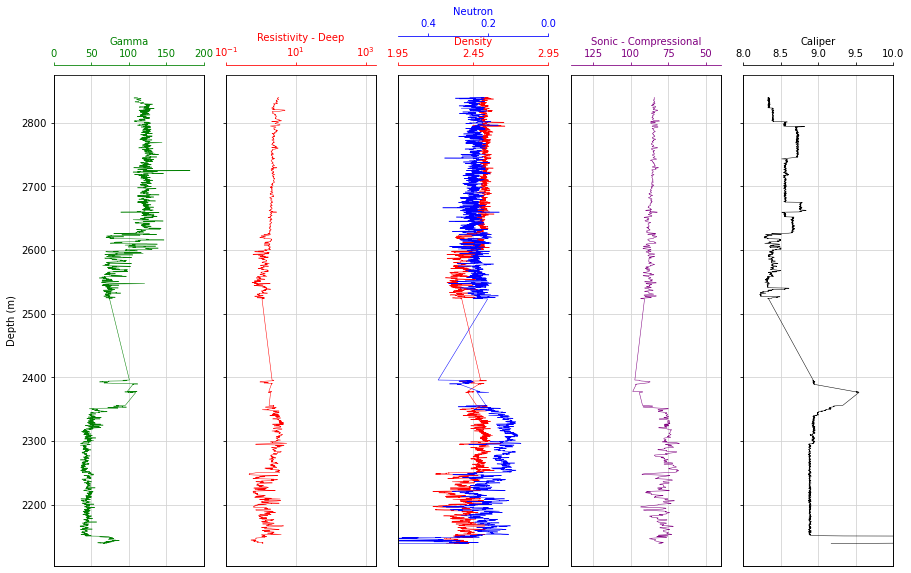

In [14]:
data_plot = train_data[train_data.WELL==np.unique(train_data.WELL.values)[0]]
plot_wirelines(data_plot)